In [1]:
#pip install -r gen_ai/requirements.txt

In [ ]:
import torch

if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))
else:
    print("No GPU found.")


## Load embeddings from here



In [3]:
##################################################################################################################################################################

In [4]:
import pickle
from typing import List, Literal
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import torch
import copy

from langchain.tools import BaseTool, Tool  # Para criar ferramentas personalizadas
#from langchain.agents import initialize_agent  # Para configurar o agente
#from langchain.chat_models import ChatOpenAI  # Para usar modelos de linguagem



thread_states = {}

# Definir o schema de estado
#class EmbeddingDict(TypedDict):
    #key1: str
    #key2: str
    #key3: str
    #key4: List[float]

class State(TypedDict):
    graph_state: str
    query: str
    embeddings_loaded: bool
    query_template: str
    query_embedding: List
    metadados: List
    top_results: List
    llm_response: str
    thread: str
    context_decision: str
    # Adicione outros campos conforme necessário

# Variável global para armazenar embeddings na memória
embeddings_in_memory = None
# Load model and tokenizer
model_id = "meta-llama/Llama-2-7b-chat-hf"  # Replace if needed
tokenizer = AutoTokenizer.from_pretrained(model_id)

# Configure BitsAndBytes for 4-bit quantization
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,  # Enable 4-bit quantization
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=False,
    bnb_4bit_quant_type="fp4",
)

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=bnb_config,  # Correct quantization parameter
    device_map="auto",
)

#embddings model
from sentence_transformers import SentenceTransformer
embeddings_model = SentenceTransformer("sentence-transformers/gtr-t5-large")



/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.30s/it]


## functions

In [5]:
# Function: Decidir o próximo nó com base no estado atualizado
def decide_next_node_embeddings(state: State) -> Literal["load_embeddings_files", "create_query_embedding"]:
    if state["embeddings_loaded"] == True:
        print("will NOT load embeddings")
        return "create_query_embedding"
    else:
        print("laoding embeddings")
        return "load_embeddings_files"

# Function: Decidir o próximo nó com base no estado atualizado
def decide_next_node_context(state: State) -> Literal["use_RAG", "specific_tool_node", "general_tool_node"]:
    if "SPECIFIC" in state["context_decision"]:
        return "specific_tool_node"
    elif "GENERAL" in state["context_decision"]:
        return "general_tool_node"
    else:       
        return "use_RAG"
    
# Function: Decidir o próximo nó com base no histórico
def decide_next_node_history(state: State) -> Literal["bring_conversation_history", "build_prompt_template"]:    
    if 1==1:
        
        return "bring_conversation_history"
    else:
        
        return "build_prompt_template"

# Function: Decidir o próximo nó com base no estado atualizado
def decide_next_node_short(state: State) -> Literal["make_history_short", END]:
    if 1==1:
        return "make_history_short"
    else:
        return END

# Func: cria mensagem de sistema
def create_system_message(context_list) -> str:
    formatted_context = []
    for result in context_list:
        # Formatar os metadados seguidos pelo texto
        formatted_entry = (
            f"Document: {result['document_name']}\n"
            f"Page: {result['page_num']}\n"
            f"Text: {result['text']}\n"
            "----------------------\n"
            )
        formatted_context.append(formatted_entry)    
    # Juntar todos os textos formatados em uma única string
    final_context = "\n".join(formatted_context)
    system_message_and_context = (
    "Check if the userer's quesiton can be answered by the content present in the context: "
    "If the answer is not in the context, say that you don't know. "
    "If the answer is in the context, just reply it based on context. "
   f"<context>{final_context}</context>"    
    )
    return system_message_and_context


from typing import List, Dict
import json
from langchain.tools import BaseTool

def load_data(file_path: str) -> List[Dict]:
    """
    Carrega os dados estruturados do arquivo JSON.
    """
    with open(file_path, 'r') as f:
        return json.load(f)

class SpecificFilterTool(BaseTool):
    name: str = "specific_filter"  # Adicione a anotação de tipo
    description: str = (
        "Use esta ferramenta para buscar apenas as informações mais relevantes com base em palavras-chave na consulta. "
        "Ideal para perguntas como: 'Qual o custo do plano Standard?'."
    )
    file_path: str = '/mnt/data/structured_subscription_data_with_categories.json'

    def _run(self, query: str):
        data = load_data(self.file_path)
        keywords = query.lower().split()
        # Filtrar os campos mais relevantes
        results = [
            entry for entry in data
            if any(keyword in entry.get("details", "").lower() for keyword in keywords)
        ]
        return results[0] if results else "Nenhuma informação específica encontrada."

    def _arun(self, query: str):
        raise NotImplementedError("Esta ferramenta não suporta execução assíncrona.")




In [6]:
DESCRIPTION_RAG = """
O RAG (Retrieval-Augmented Generation) é uma ferramenta que recupera informações externas,
como manuais, para responder a perguntas gerais e amplas.
"""

DESCRIPTION_SPECIFIC_TOOL = """
A ferramenta específica retorna apenas as informações mais relevantes relacionadas ao JSON,
como o custo de um plano ou a disponibilidade de uma funcionalidade específica.
"""

DESCRIPTION_GENERAL_TOOL = """
A ferramenta genérica retorna todas as informações relacionadas a uma consulta,
como todas as características de um plano de assinatura.
"""


## Tools

In [7]:
from langchain.tools import BaseTool

class SpecificFilterTool(BaseTool):
    name:str = "specific_filter"
    description:str = (
        "Use esta ferramenta para buscar apenas as informações mais relevantes com base em palavras-chave na consulta. "
        "Ideal para perguntas como: 'Qual o custo do plano Standard?'."
    )

    file_path:str = 'structured_subscription_data_with_categories.json'

    def _run(self, query: str):
        data = load_data(self.file_path)
        keywords = query.lower().split()
        # Filtrar os campos mais relevantes
        results = [
            entry for entry in data
            if any(keyword in entry.get("details", "").lower() for keyword in keywords)
        ]
        return results[0] if results else "Nenhuma informação específica encontrada."

    def _arun(self, query: str):
        raise NotImplementedError("Esta ferramenta não suporta execução assíncrona.")

class GeneralFilterTool(BaseTool):
    name:str = "general_filter"
    description:str = (
        "Use esta ferramenta para buscar todas as informações relacionadas com base em palavras-chave na consulta. "
        "Ideal para perguntas como: 'Quais são todas as características do plano Standard?'."
    )

    file_path:str = 'structured_subscription_data_with_categories.json'

    def _run(self, query: str):
        data = load_data(self.file_path)
        keywords = query.lower().split()
        # Filtrar todos os campos relacionados
        results = [
            entry for entry in data
            if any(keyword in entry.get("details", "").lower() for keyword in keywords)
        ]
        return results if results else "Nenhuma informação relevante encontrada."

    def _arun(self, query: str):
        raise NotImplementedError("Esta ferramenta não suporta execução assíncrona.")

## Nodes

In [8]:
# Node: Receber a query
def use_RAG(state: State) -> State:
    print("---use_RAG---")    
    state["graph_state"] = "use_RAG"
    return state

# Node: Carregar embeddings do disco e atualizar o estado
def load_embeddings_files(state: State) -> State:
    print("---load_embeddings_files---")
    
    state["graph_state"] = "load_embeddings_files" 
    with open("chunks_with_embeddings.pkl", "rb") as f:
        chunks = pickle.load(f)
    # Atualizar o estado com os embeddings carregados
    state["embeddings_loaded"] = True
    #print("Estado atualizado:", state)
    import faiss
    import numpy as np
    
    # Extraia os embeddings e metadados
    embeddings = np.array([chunk['embedding'] for chunk in chunks]).astype('float32')
    metadados = [{'text': chunk['text'], 'page_num': chunk['page_num'], 'document_name': chunk['document_name']} for chunk in chunks]

    state["metadados"] = metadados

    #print(state)
    # Inicialize o índice FAISS
    dimension = embeddings.shape[1]  # Dimensão dos embeddings
    
    global faiss_index
    faiss_index = faiss.IndexFlatL2(dimension)  # Índice de similaridade (L2 - Euclidean Distance)
    
    # Adicione os embeddings ao índice FAISS (globall)
    faiss_index.add(embeddings)
    print(f"{faiss_index.ntotal} embeddings adicionados ao índice FAISS.")    
    return state

# Node: Criar a embeddings da query
def create_query_embedding(state: State) -> State:
    print("---create_query_embedding---")
    state["graph_state"] = "create_query_embedding"    
    # Gerar o embedding da consulta usando o modelo
    query_embedding = embeddings_model.encode(state["query"]).astype('float32')
    state["query_embedding"] = query_embedding
    return state


# Node: verifica similaridade entre embeddings
def verify_embeddings_similarity_on_FAISS(state: State) -> State:
    print("---verify_embeddings_similarity---")
    state["graph_state"] = "verify_embeddings_similarity" 

    # Consultar o FAISS para encontrar os k embeddings mais próximos
    k = 3 # number of embeddings
    distances, indices = faiss_index.search(state["query_embedding"].reshape(1, -1), k)    

    metadados = state["metadados"]
    
    # Recuperar os textos correspondentes a partir dos metadados
    top_results = [metadados[idx] for idx in indices[0] if idx != -1]

    state["top_results"] = top_results 

    #delete unecessary content from state
    state["query_embedding"] = None
    #state["metadados"] = None   
    
    return state
        

# Node: Construir query_template
def build_prompt_template(state: State) -> State:
    print("---build_prompt_template---")
    state["graph_state"] = "build_prompt_template"    
    #context = state["top_results"]

    if state["thread"] in thread_states:
        # Recupera o conteúdo atual do "system" e combina com os novos resultados
        thread_system_content = thread_states[state["thread"]][0]["content"]
        combined_list = thread_system_content + state['top_results']
        unique_list = [dict(t) for t in {frozenset(d.items()) for d in combined_list}]
        
        # Atualiza apenas o conteúdo do "system"
        thread_states[state["thread"]][0]["content"] = unique_list
        
        # Adiciona a nova query como uma nova mensagem do usuário
        thread_states[state["thread"]].append({"role": "user", "content": state["query"]}) 

        #create the quert tenplate
        state["query_template"] = copy.deepcopy(thread_states[state["thread"]])
        system_message_and_context = create_system_message(state["query_template"][0]["content"])
        state["query_template"][0]["content"] = system_message_and_context        

            
    else:
        #create initial_thread
        thread_states[state["thread"]] = [{"role": "system", "content": state["top_results"]}, {"role": "user", "content": state["query"]}]        
        
        system_message_and_context = create_system_message(state["top_results"])

        state["query_template"] = copy.deepcopy([{"role": "system", "content": system_message_and_context},
                        {"role": "user", "content": state["query"]}])        
    
    return state


# Node: Chamar o LLM
def llm_call(state: State) -> State:
    print("---llm_call---")    
    state["graph_state"] = "llm_call"

    print(state["query_template"])
    # Preparar os inputs
    inputs = tokenizer.apply_chat_template(
        state["query_template"],
        tokenize=True,
        add_generation_prompt=False,
        return_tensors="pt",
        return_dict=True,
    )
    # Transferir inputs para a GPU
    inputs = {key: tensor.to("cuda", non_blocking=True) for key, tensor in inputs.items()}

    # Gerar a resposta com o modelo
    outputs = model.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_new_tokens=130,
        do_sample=True,
        num_beams=1,
        num_return_sequences=1,
        temperature=1e-5,
    )
    # Decodificar a saída
    full_response = tokenizer.decode(outputs[0], skip_special_tokens=True).strip()
    if "[/INST]" in full_response:
        # Captura tudo após a última ocorrência de </INST>
        response_only = full_response.split("[/INST]")[-1].strip()
    state["llm_response"] = response_only

    #update the threads with the llm-OUTput
    thread_states[state["thread"]].append({"role": "model", "content": response_only})
    
    return state


def make_history_short(state: State) -> State:
    print("---make_history_short---")    
    state["graph_state"] = "make_history_short" 
    if not isinstance(state, dict):
        raise TypeError("O 'state' deve ser um dicionário.")
    state["query"] = None
    state["top_results"] = None
    # Limita o histórico a 2 interações + 1 mensagem system
    if len(state["query_template"]) > 6:  # 1 mensagem 'system' + 2 mensagens 
        system_message = [copy.deepcopy(thread_states[state["thread"]][0])]
        final_dialog = copy.deepcopy(thread_states[state["thread"]][-6:])
        system_message.extend(final_dialog)
        thread_states[state["thread"]] = system_message
        
    return state

def bring_conversation_history(state: State) -> State:
    return state


def context_decision_node(state):
    """
    Usa o LLM para decidir qual ferramenta utilizar com base na query.
    """
    query = state["query"]

    # Criar o prompt para o LLM
    prompt = f"""
    Abaixo estão as descrições das ferramentas disponíveis:

    1. RAG:
    {DESCRIPTION_RAG}

    2. Ferramenta específica:
    {DESCRIPTION_SPECIFIC_TOOL}

    3. Ferramenta genérica:
    {DESCRIPTION_GENERAL_TOOL}

    Pergunta: "{query}"

    Escolha a ferramenta mais adequada para responder à pergunta.
    Responda apenas com: 'RAG', 'SPECIFIC', ou 'GENERAL'.
    """

    # Chamar o LLM com o prompt
    decision = llm.predict(prompt).strip().upper()

    # Armazenar a decisão no estado
    state["context_decision"] = decision
    return state


def specific_tool_node(state):
    """
    Processa a consulta usando a ferramenta específica.
    """
    query = state["query"]
    state["result"] = SpecificFilterTool()._run(query)
    return state

def general_tool_node(state):
    """
    Processa a consulta usando a ferramenta genérica.
    """
    query = state["query"]
    state["result"] = GeneralFilterTool()._run(query)
    return state


def tool_prompt(state):
    """
    tool_prompt
    """
    return state

In [9]:
from IPython.display import Image, display

# Criar o grafo
builder = StateGraph(State)

# Adicionar todos os nodes
builder.add_node("context_decision_node", context_decision_node)
builder.add_node("use_RAG", use_RAG)
builder.add_node("specific_tool_node", specific_tool_node)
builder.add_node("general_tool_node", general_tool_node)
builder.add_node("tool_prompt", tool_prompt)
builder.add_node("load_embeddings_files", load_embeddings_files)
builder.add_node("create_query_embedding", create_query_embedding)
builder.add_node("verify_embeddings_similarity_on_FAISS", verify_embeddings_similarity_on_FAISS)
builder.add_node("bring_conversation_history", bring_conversation_history)
builder.add_node("build_prompt_template", build_prompt_template)
builder.add_node("llm_call", llm_call)
builder.add_node("make_history_short", make_history_short)





In [10]:
# Conectar START ao primeiro node
builder.add_edge(START, "context_decision_node")

# Configurar arestas condicionais para check_embeddings
builder.add_conditional_edges(
    "context_decision_node",
    decide_next_node_context  # Passar a função que decide o próximo node
)


# Configurar arestas condicionais para check_embeddings
builder.add_conditional_edges(
    "use_RAG",
    decide_next_node_embeddings  # Passar a função que decide o próximo node
)

# Conectar os demais nodes
builder.add_edge("load_embeddings_files", "create_query_embedding")
builder.add_edge("create_query_embedding", "verify_embeddings_similarity_on_FAISS")

# Configurar arestas condicionais para check_embeddings
builder.add_conditional_edges(
    "verify_embeddings_similarity_on_FAISS",
    decide_next_node_history  # Passar a função que decide o próximo node
)
#decide_next_node_short
builder.add_edge("bring_conversation_history", "build_prompt_template")                
builder.add_edge("build_prompt_template", "llm_call")

# Configurar arestas condicionais para check_embeddings
builder.add_conditional_edges(
    "llm_call",
    decide_next_node_short  # Passar a função que decide o próximo node
)

builder.add_edge("make_history_short", END)


builder.add_edge("tool_prompt", "llm_call")

builder.add_edge("specific_tool_node", "tool_prompt")
builder.add_edge("general_tool_node", "tool_prompt")




# Conectar os nós com base na decisão
#graph.add_edge("decision", "rag", condition=lambda state: state["context_decision"] == "RAG")
#graph.add_edge("decision", "specific_tool", condition=lambda state: state["context_decision"] == "SPECIFIC")
#graph.add_edge("decision", "general_tool", condition=lambda state: state["context_decision"] == "GENERAL")

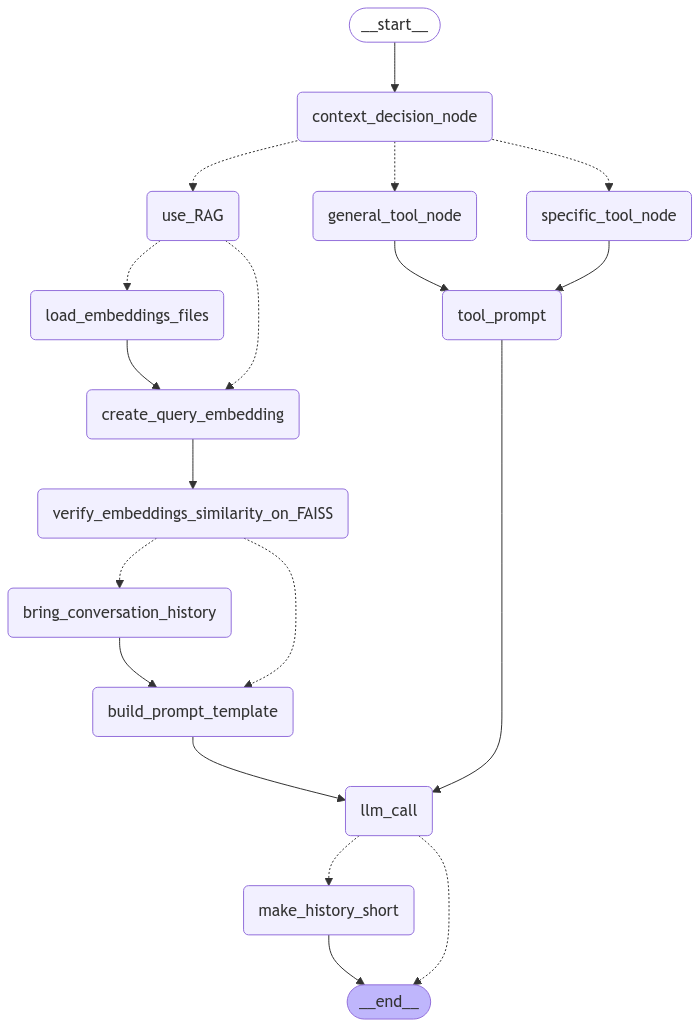

In [11]:
# Inicializa o MemorySaver e compila o gráfico
#checkpointer = MemorySaver()
# Compilar o grafo
graph = builder.compile()

#


# Visualizar o grafo (opcional)
display(Image(graph.get_graph().draw_mermaid_png()))


In [12]:
def call_graph(query, thread="1"):
    # Verificar se a variável `initial_state` está no escopo global
    if 'state' not in globals():
        global initial_state  # Declarar como global para criar ou reutilizar
        initial_state = {
            "graph_state": "START",  # Ponto de entrada do grafo
            "query": query,
            "embeddings": [],  # Inicialmente vazio
            "embeddings_loaded": False,
            "thread": thread,
        }
    
    else:
        initial_state = state
        initial_state["query"] = query
        
    # Executar o grafo
    result = graph.invoke(initial_state)
    
    # Verificar o resultado final
    return result



In [13]:
# Ferramentas JSON
specific_tool = SpecificFilterTool()
general_tool = GeneralFilterTool()

# Ferramenta JSON com descrição
json_tool = JsonTool(
    document_description=DOCUMENT_DESCRIPTION,
    tools=[specific_tool, general_tool],
)

# FAISS ou outra ferramenta
faiss_tool = Tool(
    name="faiss_retriever",
    func=lambda query: f"Buscando no FAISS: {query}",  # Substitua pelo real FAISS
    description="Use esta ferramenta para buscar informações gerais que não estejam relacionadas ao documento JSON."
)

# Configurar o agente
tools = [
    Tool(name="json_tool", func=json_tool.run, description="Use para perguntas relacionadas aos planos Standard e Gold Star."),
    faiss_tool,
]


NameError: name 'JsonTool' is not defined

In [13]:
# Solicitar entrada do usuário
user_input = input("Enter your question or instruction: ")

# Passar o input do usuário para o call_graph
state = call_graph(user_input, thread="1")

# Exibir a resposta do LLM
print(state["llm_response"])


---receive_query---
will NOT load embeddings
---create_query_embedding---
---verify_embeddings_similarity---
---build_prompt_template---
---llm_call---
[{'role': 'system', 'content': "Check if the userer's quesiton can be answered by the content present in the context: If the answer is not in the context, say that you don't know. If the answer is in the context, just reply it based on context. <context>Document: smart_baby_camera.pdf\nPage: 22\nText: Sciences et Développement économique Canada applicables aux appareils radio exempts de licence. L'exploitation est autorisée aux deux conditions suivantes : 1) L'appareil ne doit pas produire de brouillage; 2) L'appareil doit accepter tout brouillage radioélectrique subi, même si le brouillage est susceptible d'en compromettre le fonctionnement. CAN ICES-3(B)/NMB-3(B) This device contains licence-exempt transmitter(s)/receiver(s) that comply with Innovation, Science and Economic Development\n----------------------\n\nDocument: smart_baby_c

In [43]:
state = call_graph("How can I turn the equipment off?", thread="1")
print(state["llm_response"])

---receive_query---
will NOT load embeddings
---create_query_embedding---


Batches: 100%|██████████| 1/1 [00:00<00:00, 90.90it/s]

---verify_embeddings_similarity---
---build_prompt_template---
---llm_call---
[{'role': 'system', 'content': "Check if the userer's quesiton can be answered by the content present in the context: If the answer is not in the context, say that you don't know. If the answer is in the context, just reply it based on context. <context>Document: smart_baby_camera.pdf\nPage: 25\nText: Cleaning and maintenance (camera) - ● Please use a clean dry cloth for cleaning and wiping. - ● Do not use strong solvents such as thinners, benzene-containing solvents or other chemical solvents next to or on this product. - ● This product only features splash-proof water protection. Please do not expose the product to water splashes, showers, or any contact with sea water, salt water, chlorinated water or beverages and other liquids. Improper use will void your warranty. - ● Before cleaning\n----------------------\n\nDocument: smart_baby_camera.pdf\nPage: 22\nText: may cause harmful interference to radio commu

---make_history_short---
According to the document, to turn off the equipment, you can follow these steps:

1. Ensure power is turned off, and the power cord from the AC adapter is disconnected. (Page 25)

So, to answer your question, you can turn off the equipment by disconnecting the power cord from the AC adapter and ensuring that the power is turned off.


In [44]:
#######################################################################

In [12]:
state["llm_response"]

'Based on the provided context, the answer to the user\'s question "Is it safe to use the baby camera with the Wi-Fi feature?" is not found in the provided document. The document only provides information on the technical specifications of the baby camera and its components, but does not address the safety of using the device.\n\nTherefore, I would reply to the user with a message that I don\'t know the answer to their question based on the provided context.'

In [14]:
thread_states

{'1': [{'role': 'system',
   'content': [{'page_num': 22,
     'text': "Sciences et Développement économique Canada applicables aux appareils radio exempts de licence. L'exploitation est autorisée aux deux conditions suivantes : 1) L'appareil ne doit pas produire de brouillage; 2) L'appareil doit accepter tout brouillage radioélectrique subi, même si le brouillage est susceptible d'en compromettre le fonctionnement. CAN ICES-3(B)/NMB-3(B) This device contains licence-exempt transmitter(s)/receiver(s) that comply with Innovation, Science and Economic Development",
     'document_name': 'smart_baby_camera.pdf'},
    {'text': 'Freestanding Installation 18',
     'page_num': 18,
     'document_name': 'smart_baby_camera.pdf'},
    {'text': 'Package Contents 17',
     'page_num': 17,
     'document_name': 'smart_baby_camera.pdf'},
    {'text': 'Camera Pairing and App Setup 4. Internet connections and device pairing 14',
     'document_name': 'smart_baby_camera.pdf',
     'page_num': 14},
   

In [15]:
state["query_template"]

[{'role': 'system',
  'content': "Check if the userer's quesiton can be answered by the content present in the context: If the answer is not in the context, say that you don't know. If the answer is in the context, just reply it based on context. <context>Document: smart_baby_camera.pdf\nPage: 22\nText: Sciences et Développement économique Canada applicables aux appareils radio exempts de licence. L'exploitation est autorisée aux deux conditions suivantes : 1) L'appareil ne doit pas produire de brouillage; 2) L'appareil doit accepter tout brouillage radioélectrique subi, même si le brouillage est susceptible d'en compromettre le fonctionnement. CAN ICES-3(B)/NMB-3(B) This device contains licence-exempt transmitter(s)/receiver(s) that comply with Innovation, Science and Economic Development\n----------------------\n\nDocument: smart_baby_camera.pdf\nPage: 18\nText: Freestanding Installation 18\n----------------------\n\nDocument: smart_baby_camera.pdf\nPage: 17\nText: Package Contents 1